# OCR-Net for graphene detection

## Includes and preparation

### Downloading the dataset

In [19]:
import os

RESOURCES_DIR = '../resources/'
MODELS_DIR = os.path.join(RESOURCES_DIR, 'models')
PROJECT_DIR = os.path.join(MODELS_DIR, 'OCRNet')
PRETRAINED_DIR = os.path.join(PROJECT_DIR, 'pretrained')
DATASET_DIR = os.path.join(RESOURCES_DIR, 'dataset')
CHECKPOINT_DIR = os.path.join(PROJECT_DIR, 'checkpoints')
LOG_DIR = os.path.join(PROJECT_DIR, 'logs')

for directory in [RESOURCES_DIR, MODELS_DIR, PROJECT_DIR, PRETRAINED_DIR, CHECKPOINT_DIR, LOG_DIR]:
    if not os.path.exists(directory):
        os.mkdir(directory)

PRETRAINED_RESNET_PATH = os.path.join(PRETRAINED_DIR, 'resnet101-imagenet.pth')
PRETRAINED_HRNET_PATH = os.path.join(PRETRAINED_DIR, 'hrnetv2_w48_imagenet_pretrained.pth')

Install gdown and other packages

In [3]:
%pip install --upgrade pip
%pip install gdown
%pip install wandb
%pip install Ninja
%pip install lightning
%pip install yacs
%pip install onnx

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 94.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nv

Then download `dataset.zip`

In [16]:
import gdown
import os

DATASET_URL = '1QIVaW6s2R-C5YYoEGIjdf-r01mF7nyeV'

if not os.path.exists(RESOURCES_DIR):
  os.mkdir(RESOURCES_DIR)
gdown.download(id=DATASET_URL, output=os.path.join(RESOURCES_DIR, 'dataset.zip'))

Downloading...
From (uriginal): https://drive.google.com/uc?id=1QIVaW6s2R-C5YYoEGIjdf-r01mF7nyeV
From (redirected): https://drive.google.com/uc?id=1QIVaW6s2R-C5YYoEGIjdf-r01mF7nyeV&confirm=t&uuid=29105da6-9197-4dba-81c5-d9463be37018
To: /home/coder/project/resources/dataset.zip
100%|██████████| 33.5M/33.5M [00:02<00:00, 15.0MB/s]


'../resources/dataset.zip'

Finally, unzip the `dataset.zip` file

In [17]:
!echo A | unzip ../resources/dataset.zip -d ../resources/

Archive:  ../resources/dataset.zip
   creating: ../resources/dataset/
   creating: ../resources/dataset/extracting/
  inflating: ../resources/dataset/extracting/out.txt  
  inflating: ../resources/dataset/extracting/image.png  
  inflating: ../resources/dataset/extracting/image2.png  
  inflating: ../resources/dataset/extracting/all_img.png  
  inflating: ../resources/dataset/extracting/raw.txt  
  inflating: ../resources/dataset/extracting/extractor.ipynb  
   creating: ../resources/dataset/val/
   creating: ../resources/dataset/val/pure/
   creating: ../resources/dataset/val/pure/mask/
  inflating: ../resources/dataset/val/pure/mask/100x-1ml-1bl-1.json  
  inflating: ../resources/dataset/val/pure/mask/100x-1ml-9.json  
  inflating: ../resources/dataset/val/pure/mask/100x-bl-1.json  
  inflating: ../resources/dataset/val/pure/mask/3-14-100(1).json  
  inflating: ../resources/dataset/val/pure/mask/2-2-100x 1-2-3 layer.json  
  inflating: ../resources/dataset/val/pure/mask/G1-14-100X.js

### Download pretrained models

In [20]:
RESNET_ID = '13xtUXZ4l1UMOueG4ydh2GcFysfvi_1yB'
HRNET_ID = '1dsJevg9FOTcTYj1Uc0l2x_EkDYEuUczf'


gdown.download(id=RESNET_ID, output=PRETRAINED_RESNET_PATH)
gdown.download(id=HRNET_ID, output=PRETRAINED_HRNET_PATH)


Downloading...
From (uriginal): https://drive.google.com/uc?id=13xtUXZ4l1UMOueG4ydh2GcFysfvi_1yB
From (redirected): https://drive.google.com/uc?id=13xtUXZ4l1UMOueG4ydh2GcFysfvi_1yB&confirm=t&uuid=067da7d5-2d31-40b3-9780-456ff0f38176
To: /home/coder/project/resources/models/OCRNet/pretrained/resnet101-imagenet.pth
100%|██████████| 179M/179M [00:04<00:00, 41.4MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1dsJevg9FOTcTYj1Uc0l2x_EkDYEuUczf
From (redirected): https://drive.google.com/uc?id=1dsJevg9FOTcTYj1Uc0l2x_EkDYEuUczf&confirm=t&uuid=5ed31b32-beec-4771-8d2e-8f04d73a21cb
To: /home/coder/project/resources/models/OCRNet/pretrained/hrnetv2_w48_imagenet_pretrained.pth
100%|██████████| 311M/311M [00:06<00:00, 44.6MB/s]


'../resources/models/OCRNet/pretrained/hrnetv2_w48_imagenet_pretrained.pth'

### Import everything

In [21]:
from lib.models.model_manager import ModelManager
from lib.utils.tools.configer import Configer
from matplotlib import pyplot as plt
import numpy as np
import json
import torch
import os
from PIL import Image
import torchvision.transforms as transforms
import lightning.pytorch as pl
import wandb
import torchmetrics
from tqdm import tqdm
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
%env WANDB_NOTEBOOK_NAME=OCRNet.ipynb
wandb.login()

wandb: Currently logged in as: iluxa-kholkin (graphene). Use `wandb login --relogin` to force relogin


env: WANDB_NOTEBOOK_NAME=OCRNet.ipynb


True

## Parameters

In [23]:
#@title Mapping from a label to an index

label_to_ind = {"BG": 0, "ML": 1, "BL": 2, "3L": 3}
ind_to_label = {val: key for key, val in label_to_ind.items()}  # inverse of label_to_ind
label_to_color = {
  "BG": torch.tensor([227, 217, 207]),
  "ML": torch.tensor([176, 179, 162]),
  "BL": torch.tensor([109, 121, 117]),
  "3L": torch.tensor([63, 56, 46]),
}
label_to_name = {
  "BG": 'Background',
  "ML": 'Monolayer',
  "BL": 'Bilayer',
  "3L": 'Three layers',
}




In [27]:
#@title Parameters

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

# both corrections cannot be applied together
APPLY_GAMMA_CORRECTION = False
APPLY_MEDIAN_CORRECTION = True

LOAD_SCRAPED = False

BACKBONE = 'resnet'  # 'hrnet', 'resnet'

FINE_LOSS_WEIGHT = 1
COARSE_LOSS_WEIGHT = 0.4

DEFAULT_IMAGE_SIZE = (500, 500)
DEFAULT_BATCH_SIZE = 15
TRAIN_BATCH_SIZE = DEFAULT_BATCH_SIZE
VAL_BATCH_SIZE = 18 if LOAD_SCRAPED else 11

LEARNING_RATE = 5e-6

DEFAULT_GAMMA_CORRECTION_ALPHA = 0.561
DEFAULT_MEDIAN_INTENSITY = 0.6

NUM_CLASSES = len(label_to_ind)
CLASS_WEIGHTS = torch.zeros(NUM_CLASSES)
CLASS_WEIGHTS[label_to_ind['BG']] = 1
CLASS_WEIGHTS[label_to_ind['ML']] = 1.25
CLASS_WEIGHTS[label_to_ind['BL']] = 1.2
CLASS_WEIGHTS[label_to_ind['3L']] = 1.5
# normalization will be done by the model, so that logging logs sane values
# CLASS_WEIGHTS = CLASS_WEIGHTS / torch.sum(CLASS_WEIGHTS)

TRAIN_BATCHES = 50
VAL_BATCHES = 1

MAX_EPOCHS = 50

## Loading the model

In [28]:
#@title OCR Model getter function

def get_ocr_model(num_classes, backbone: str = 'resnet'):
  # define params of a configer
  if backbone == 'resnet':
    params = {
      "data": {
        "num_classes": num_classes,
      },
      "network": {
        "backbone": "deepbase_resnet101_dilated8",
        "multi_grid": [1, 1, 1],
        "model_name": "spatial_ocrnet",  # "base_ocnet",
        "bn_type": "torchbn",
        "stride": 8,
        "factors": [[8, 8]],
        "loss_weights": {
          "corr_loss": 0.01,
          "aux_loss": 0.4,
          "seg_loss": 1.0
        },
        "pretrained": PRETRAINED_RESNET_PATH,
      },
    }
  elif backbone == 'hrnet':
    params = {
      "data": {
        "num_classes": num_classes,
      },
      "network": {
        "backbone": "hrnet48",
        "multi_grid": [1, 1, 1],
        "model_name": "hrnet_w48_ocr",
        "bn_type": "torchbn",
        "pretrained": PRETRAINED_HRNET_PATH,
      },
    }
  else:
    raise RuntimeError(f'Unexpected backbone type: "{backbone}"". Should be either "resnet" or "hrnet".')

  # create a configer
  configer = Configer(config_dict=params)
  # create a model manager 
  manager = ModelManager(configer)
  # return the model
  return manager.semantic_segmentor().to(device)

## Adaptive Gamma Correction

In [29]:
#@title Conversion from RGB to YCbCr and backwards
# Constants are taken from here: https://learn.microsoft.com/en-us/openspecs/windows_protocols/ms-rdprfx/b550d1b5-f7d9-4a0c-9141-b3dca9d7f525?redirectedfrom=MSDN

def rgb_to_ybr(image):
  assert image.ndim == 3
  matrix = np.array([
    [0.299, -0.168935, 0.499813],
    [0.587, -0.331665, -0.418531],
    [0.114, 0.50059, -0.081282]
  ])

  result = np.matmul(np.expand_dims(image.astype(np.float32).transpose((1, 2, 0)), 2), matrix).squeeze().transpose(
    (2, 0, 1))
  return result


def ybr_to_rgb(image):
  assert image.ndim == 3
  matrix = np.linalg.inv(np.array([
    [0.299, -0.168935, 0.499813],
    [0.587, -0.331665, -0.418531],
    [0.114, 0.50059, -0.081282]
  ]))

  result = np.matmul(np.expand_dims(image.astype(np.float32).transpose((1, 2, 0)), 2), matrix).squeeze().transpose(
    (2, 0, 1))
  return result


In [30]:
def adaptive_gamma_correction(image: np.ndarray, alpha: float = DEFAULT_GAMMA_CORRECTION_ALPHA):
  """
  Applying Adaptive Gamma Correction with parameter alpha.

  :param alpha: parameter of weighted distribution
  :param image: torch.Tensor of size (3, H, W)
  :return: torch.Tensor of size (3, H, W) - corrected image
  """
  assert image.ndim == 3

  ybr_image = np.round(rgb_to_ybr(image)).astype(np.int32)

  ybr_image[0] = 255 - ybr_image[0]

  pdf = np.bincount(ybr_image[0].flatten())
  pdf = pdf.astype(np.float32) / pdf.sum()

  pdf_max = pdf.max()
  pdf_min = pdf.min()
  l_max = pdf.shape[0]

  pdf_w = pdf_max * (((pdf - pdf_min) / (pdf_max - pdf_min)) ** alpha)

  cdf_w = np.cumsum(pdf_w, axis=0) / pdf_w.sum()

  gamma = np.take(cdf_w, ybr_image[0].flatten().astype(np.int32), 0).reshape(ybr_image.shape[1:])

  transformed_luma = 255 - l_max * ((ybr_image[0] / l_max) ** (1 - gamma))

  transformed_image = ybr_image
  transformed_image[0] = transformed_luma

  return ybr_to_rgb(transformed_image).astype(np.uint8)

## Dataset class

Labels description:


|Label   |Index|Description       |
|--------|-----|------------------|
|BG      |0    |background        |
|ML      |1    |monolayer graphene|
|BL      |2    |bilayer graphene  |

In [33]:

#@title Deafult resizer

default_resizer = transforms.Resize(DEFAULT_IMAGE_SIZE, antialias=True)


def resize(image: np.ndarray, size=DEFAULT_IMAGE_SIZE):
  image = cv2.resize(image.transpose((1, 2, 0)), size)
  if image.ndim == 2:
    image = image[:, :, None]
  return image.transpose((2, 0, 1))

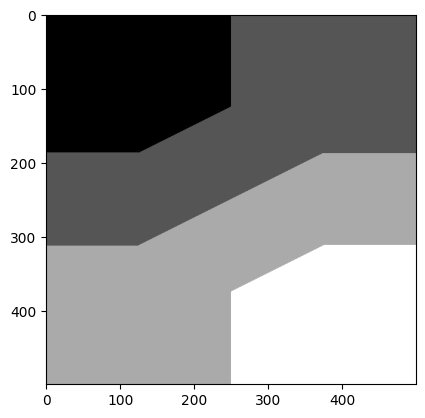

In [34]:
image = np.array([[[1, 2], [3, 4]]])
with torch.no_grad():
  image = default_resizer(torch.tensor(image)).detach().numpy()
plt.imshow(image.transpose((1, 2, 0)), cmap='gray')
plt.show()

In [35]:
#@title Functions for printing the images conveniently

def print_images(images: list, labels: list, params=[]):
  for i in range(len(images)):
    if isinstance(images[i], torch.Tensor):
      images[i] = images[i].detach().cpu().numpy()
    if images[i].ndim == 2:
      images[i] = images[i][None, :, :]
    images[i] = images[i].transpose((1, 2, 0))
  n = len(images)
  fig, ax = plt.subplots(1, n, figsize=(10, 20 * n))
  if len(params) < n:
    params += [{} for i in range(n - len(params))]
  if n > 1:
    for i in range(n):
      ax[i].axis('off')
      ax[i].imshow(images[i], **params[i])
      ax[i].set_title(labels[i], fontsize=14)
  else:
    plt.axis('off')
    ax.imshow(images[0], **params[0])
    ax.set_title(labels[0], fontsize=14)
  plt.show()


@torch.no_grad()
def print_img_msk(image: np.ndarray, masks):
  img = resize(image)
  step = 255 // 3
  msk_ML = resize((masks[label_to_ind['ML'], :, :] * step)[None, :, :])
  msk_DL = resize((masks[label_to_ind['BL'], :, :] * 2 * step)[None, :, :])
  msk_3L = resize((masks[label_to_ind['3L'], :, :] * 3 * step)[None, :, :])
  print_images([img, np.clip(msk_3L + msk_DL + msk_ML, 0, 255)],
               ['Image', 'Ground Truth'],
               [{}, {'cmap': 'gray'}])


In [36]:
#@title The Class holding the dataset
# This is very specific to the dataset.
# So, you need to change it if you have a different one.

mask_threshold = 254


def get_pic_filenames(dataset_type: str, pic_type: str):
  # dataset_type is either 'train' or 'val'
  # pic_type is either 'pure' or 'scraped'
  path = os.path.join(DATASET_DIR, dataset_type, pic_type, 'raw')
  possible_extensions = ('.jpg', '.png')
  pictures = np.array(
    list(filter(lambda file: file.endswith(possible_extensions), os.listdir(path))))
  return pictures


class Dataset:
  def __init__(self, dataset_type: str, load_scraped=LOAD_SCRAPED):
    self.images = []
    self.masks = []
    self.median_corrected_images = None
    self.corrected_images = None

    self.load_pure_images(dataset_type)
    if load_scraped:
      self.load_scraped_images(dataset_type)

    self.num_images = len(self.images)
    self.image_ids = torch.arange(self.num_images)

  def load_pure_images(self, dataset_type):
    pic_filenames = get_pic_filenames(dataset_type, "pure")
    path_pure_raw = os.path.join(DATASET_DIR, dataset_type, "pure", "raw")
    path_pure_mask = os.path.join(DATASET_DIR, dataset_type, "pure", "mask")

    self.images += [np.array(Image.open(os.path.join(path_pure_raw, pic))).transpose((2, 0, 1)) for pic in
                    tqdm(pic_filenames)]
    # print(pic_filenames)
    for pic in pic_filenames:
      with open(os.path.join(path_pure_mask, pic[:-4] + ".json"), 'r') as file:
        d = json.load(file)
        mask = np.zeros((NUM_CLASSES, d['imageHeight'], d['imageWidth']), np.uint8)
        for shape in d['shapes']:
          if shape['label'] not in label_to_ind.keys():
            raise RuntimeError('Unexpected label')
          polygon = np.array(shape['points'], np.int32)
          curmask = np.copy(mask[label_to_ind[shape['label']], :, :])
          cv2.fillPoly(curmask, [polygon], 1)
          mask[label_to_ind[shape['label']], :, :] = curmask
        mask[label_to_ind["BG"]] = np.ones((d['imageHeight'], d['imageWidth']), np.uint8) - np.clip(
          np.sum(mask, axis=0), 0, 1)
        self.masks.append(mask)

  def load_scraped_images(self, dataset_type):
    SCRAPED_SIZE = (182, 182)

    path_raw = os.path.join(DATASET_DIR, dataset_type, "scraped", "raw")
    path_ML = os.path.join(DATASET_DIR, dataset_type, "scraped", "mask", "ML")
    path_BL = os.path.join(DATASET_DIR, dataset_type, "scraped", "mask", "BL")
    scraped_filenames = get_pic_filenames(dataset_type, "scraped")

    self.images += [np.array(Image.open(os.path.join(path_raw, filename)).transpose((2, 0, 1))) for filename in
                    scraped_filenames]
    # print(self.images[-1].shape)

    for filename in tqdm(scraped_filenames):
      mask = np.zeros((NUM_CLASSES, SCRAPED_SIZE[0], SCRAPED_SIZE[1]), dtype=np.uint8)
      mask[label_to_ind['ML'], :, :] = np.array(Image.open(os.path.join(path_ML, filename)))[:, :, 0] >= mask_threshold
      mask[label_to_ind['BL'], :, :] = np.array(Image.open(os.path.join(path_BL, filename)))[:, :, 0] >= mask_threshold
      mask[label_to_ind['BG'], :, :] = np.ones(SCRAPED_SIZE) - np.clip(np.sum(mask), 0, 1)
      self.masks.append(mask)

  def load_image(self, index, corrected=False, alpha=DEFAULT_GAMMA_CORRECTION_ALPHA, median_corrected=False,
                 median_intensity=0.6):
    assert not median_corrected or not corrected
    if median_corrected:
      if self.median_corrected_images is not None:
        return self.median_corrected_images[index]
      else:
        return self._correct_median(self.images[index], median_intensity)
    if corrected:
      if self.corrected_images is not None:
        return self.corrected_images[index]
      else:
        return adaptive_gamma_correction(self.images[index], alpha)
    return self.images[index]

  def prepare_gamma_corrected(self, alpha=DEFAULT_GAMMA_CORRECTION_ALPHA):
    self.corrected_images = []
    for i in tqdm(range(self.num_images)):
      self.corrected_images.append(adaptive_gamma_correction(self.images[i], alpha))

  def _correct_median(self, image, intensity):
    image = image / 255.
    r, g, b = image[0], image[1], image[2]
    rmedian, gmedian, bmedian = np.median(r), np.median(g), np.median(b)
    result = image
    result[0, :, :] *= intensity / rmedian
    result[1, :, :] *= intensity / gmedian
    result[2, :, :] *= intensity / bmedian
    return np.clip(result * 255, 0, 255).astype(np.uint8)

  def prepare_median_corrected(self, intensity=DEFAULT_MEDIAN_INTENSITY):
    self.median_corrected_images = []
    for i in tqdm(range(self.num_images)):
      self.median_corrected_images.append(self._correct_median(self.images[i], intensity))

  def load_mask(self, index):
    return self.masks[index], torch.tensor([*label_to_ind.values()])


def get_train_val_datasets(load_scraped):
  return Dataset("train", load_scraped), Dataset("val", load_scraped)

In [37]:
with torch.no_grad():
  dataset_train, dataset_val = get_train_val_datasets(LOAD_SCRAPED)

100%|██████████| 11/11 [00:00<00:00, 156.76it/s]


In [38]:
with torch.no_grad():
  if APPLY_GAMMA_CORRECTION:
    dataset_train.prepare_gamma_corrected()
    dataset_val.prepare_gamma_corrected()
  if APPLY_MEDIAN_CORRECTION:
    dataset_train.prepare_median_corrected()
    dataset_val.prepare_median_corrected()

100%|██████████| 11/11 [00:00<00:00, 38.04it/s]


In [39]:
print(f'{dataset_train.num_images} -- train size')
print(f'{dataset_val.num_images} -- val size')

98 -- train size
11 -- val size


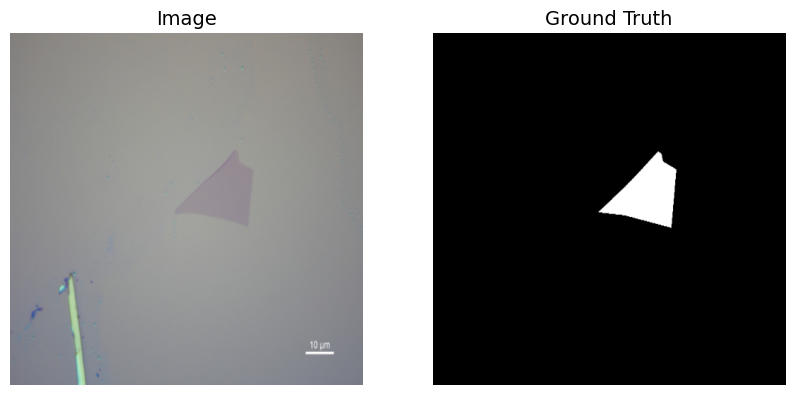

In [40]:
#@title `dataset_train.load_image{mask}(index)` { run: "auto"}
index = 18  #@param {type:"slider", min:0, max:147, step:1}

print_img_msk(dataset_train.load_image(index), dataset_train.load_mask(index)[0])

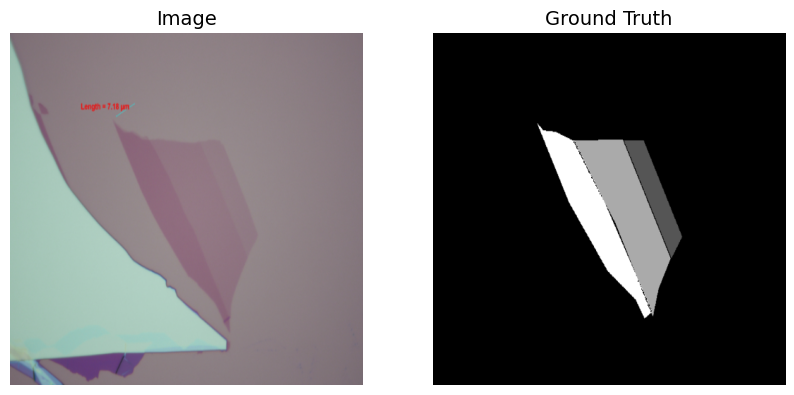

In [41]:
#@title `dataset_val.load_image{mask}(index)` { run: "auto"}
index = 0  #@param {type:"slider", min:0, max:17, step:1}

print_img_msk(dataset_val.load_image(index), dataset_val.load_mask(index)[0])

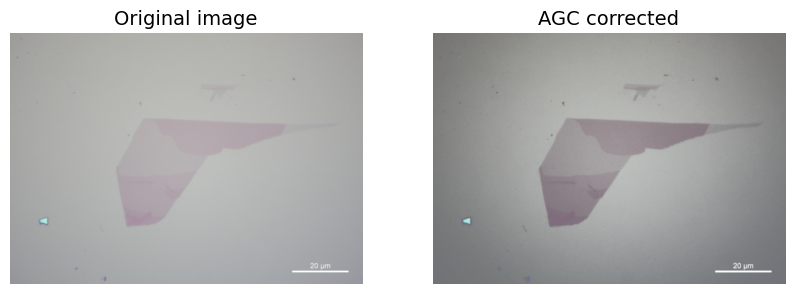

In [42]:
#@title Print Gamma corrected { run: "auto"}
index = 0  #@param {type:"slider", min:0, max:147, step:1}

image = dataset_train.load_image(index)
corrected_image = dataset_train.load_image(index, corrected=True)
print_images([image, corrected_image], ["Original image", "AGC corrected"])

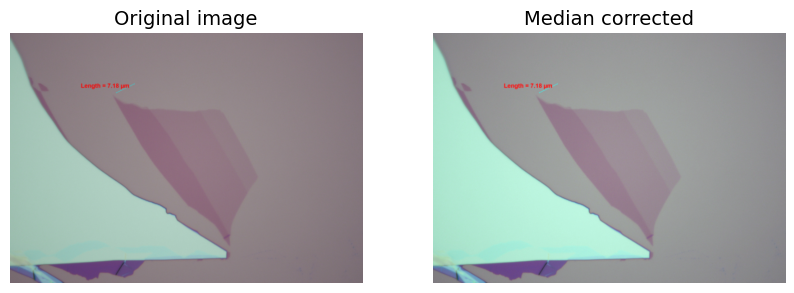

In [49]:
#@title Print Median corrected { run: "auto"}
index = 0  #@param {type:"slider", min:0, max:11, step:1}

image = dataset_val.load_image(index)
corrected_image = dataset_val.load_image(index, median_corrected=True)
print_images([image, corrected_image], ["Original image", "Median corrected"])

## Data loader

In [50]:
#@title Image augmentor
import torchvision.transforms.functional as TF
import random


class Augmenter:
  def __init__(self, vert_flip_prob, hor_flip_prob, randomAffine):
    self.vert_flip_prob = vert_flip_prob
    self.hor_flip_prob = hor_flip_prob
    self.randomAffine = randomAffine

  def __call__(self, images, masks):
    if random.random() > self.vert_flip_prob:
      images = TF.vflip(images)
      masks = TF.vflip(masks)
    if random.random() > self.hor_flip_prob:
      images = TF.hflip(images)
      masks = TF.hflip(masks)

    params = self.randomAffine.get_params(self.randomAffine.degrees, self.randomAffine.translate,
                                          self.randomAffine.scale, self.randomAffine.shear, images.shape[-2:][::-1])
    images = TF.affine(images, *params)
    masks = TF.affine(masks, *params)

    return images, masks

In [51]:
random_aug = Augmenter(0.5, 0.5, transforms.RandomAffine(degrees=(0, 360), translate=(0.2, 0.2), scale=(0.7, 1.5),
                                                         shear=(0, 0.2, 0, 0.2)))

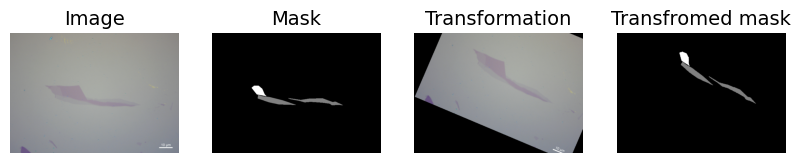

In [52]:
#@title Show augmenatation results. { run:'auto' }

index = 7  #@param {type: 'slider', min:0, max:57, step:1}

image = dataset_train.load_image(index, corrected=APPLY_GAMMA_CORRECTION,
                                 median_corrected=APPLY_MEDIAN_CORRECTION).astype(np.float32)
mask = dataset_train.load_mask(index)[0]
intens_ml = 255 // 3
intens_bl = 2 * intens_ml
intens_3l = 3 * intens_ml
mask = np.expand_dims(mask[label_to_ind['ML']] * intens_ml +
                      mask[label_to_ind['BL']] * intens_bl +
                      mask[label_to_ind['3L']] * intens_3l, 0)

with torch.no_grad():
  timg, tmsk = random_aug(torch.tensor(image), torch.tensor(mask))

  print_images([image.astype(np.uint8), mask.astype(np.uint8), timg.to(torch.uint8), tmsk],
               ["Image", "Mask", "Transformation", "Transfromed mask"],
               [{}, {'cmap': 'gray'}, {}, {'cmap': 'gray'}])

In [53]:
#@title Normalization Functions

default_mean_unnormalizer = IMAGENET_MEAN[None, :, None, None]
default_var_unnormalizer = IMAGENET_STD[None, :, None, None]


def normalize(image: np.ndarray):
  return (image - IMAGENET_MEAN[:, None, None]) / IMAGENET_STD[:, None, None]


def unnormalize(normalized_image: np.ndarray):
  three_dims = False
  if normalized_image.ndim == 3:
    three_dims = True
    normalized_image = normalized_image[None, :, :, :]
  result = normalized_image * default_var_unnormalizer + default_mean_unnormalizer
  result = np.clip(result, 0., 1.)
  if three_dims:
    return result.squeeze()
  return result


In [54]:
#@title Data loader

def data_loader(dataset,
                augmenter=None,
                batch_size=DEFAULT_BATCH_SIZE,
                image_size=DEFAULT_IMAGE_SIZE,
                choose_unique=False,
                corrected=APPLY_GAMMA_CORRECTION,
                median_corrected=APPLY_MEDIAN_CORRECTION
                ):
  while True:

    #extract a random batch 
    batch = np.random.choice(dataset.image_ids, size=batch_size, replace=not choose_unique)

    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []

    for f in batch:
      #preprocess the raw images
      raw = dataset.load_image(f, corrected=corrected, median_corrected=median_corrected) / 255.

      raw = normalize(cv2.resize(raw.transpose((1, 2, 0)), DEFAULT_IMAGE_SIZE).transpose((2, 0, 1)))

      #get the mask
      mask = dataset.load_mask(f)[0]
      mask = cv2.resize(mask.transpose(1, 2, 0), DEFAULT_IMAGE_SIZE).transpose((2, 0, 1))

      # pre-process the mask
      mask[mask != 0] = 1
      batch_x.append(raw)
      batch_y.append(mask)

    # pre-process a batch of images and masks 
    batch_x = torch.FloatTensor(np.stack(batch_x, axis=0))  # normalize raw images
    batch_y = torch.FloatTensor(np.stack(batch_y, axis=0).astype(np.float32))  # casting to float

    if augmenter:
      # augment images and masks
      batch_x, batch_y = augmenter(batch_x, batch_y)

    yield (batch_x, batch_y)

In [55]:
#@title Creating generator for training and testing
train_generator = data_loader(dataset_train, augmenter=random_aug, batch_size=TRAIN_BATCH_SIZE,
                              image_size=DEFAULT_IMAGE_SIZE, choose_unique=False, corrected=APPLY_GAMMA_CORRECTION)

val_generator = data_loader(dataset_val, augmenter=None, batch_size=VAL_BATCH_SIZE, image_size=DEFAULT_IMAGE_SIZE,
                            choose_unique=True, corrected=APPLY_GAMMA_CORRECTION)

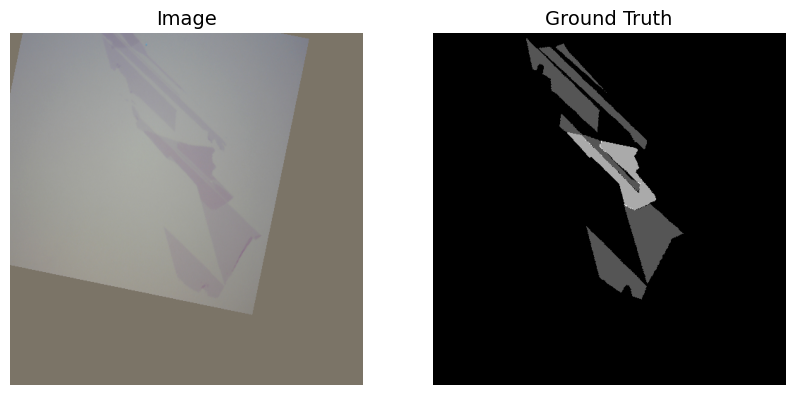

In [56]:
#@title Looking at trian generator
for x, y in train_generator:
  img = x[0]
  msk = y[0]

  print_images([unnormalize(img), msk[label_to_ind['ML']] * (255 // 3) + msk[label_to_ind['BL']] * 2 * (255 // 3) + msk[
    label_to_ind['3L']] * 3 * (255 // 3)], ['Image', 'Ground Truth'], [{}, {'cmap': 'gray'}])
  break

## Training

In [59]:
#@title Lightning model class

class LitOCR(pl.LightningModule):
  def __init__(self, num_classes, class_weights, load_scraped=True, apply_gamma_correction=False, backbone='resnet',
               fine_loss_weight=1, coarse_loss_weight=0, learning_rate=1e-5, apply_median_correction=False, image_size=(256, 256)):
    super().__init__()
    assert num_classes == class_weights.shape[0]

    # self hyperparams for later access
    self.num_classes = num_classes
    self.class_weights = class_weights
    self.load_scraped = load_scraped
    self.apply_gamma_correction = apply_gamma_correction
    self.backbone = backbone
    self.learning_rate = learning_rate
    self.fine_loss_weight = fine_loss_weight
    self.coarse_loss_weight = coarse_loss_weight
    self.apply_median_correction = apply_median_correction
    self.image_size = image_size
    # log hyperparams
    self.save_hyperparameters()


    # get a model
    self.model = get_ocr_model(num_classes, backbone)
    # configure a loss
    self.loss = torch.nn.CrossEntropyLoss(weight=class_weights / class_weights.sum())

    # configure metrics for train
    self.train_miou = torchmetrics.classification.JaccardIndex(task='multiclass', num_classes=num_classes,
                                                               average='macro')
    self.train_precision = torchmetrics.classification.Precision(task='multiclass', num_classes=num_classes,
                                                                 average='macro')
    self.train_recall = torchmetrics.classification.Recall(task='multiclass', num_classes=num_classes, average='macro')
    # configure metrics for val
    self.val_miou = torchmetrics.classification.JaccardIndex(task='multiclass', num_classes=num_classes,
                                                             average='macro')
    self.val_precision = torchmetrics.classification.Precision(task='multiclass', num_classes=num_classes,
                                                               average='macro')
    self.val_recall = torchmetrics.classification.Recall(task='multiclass', num_classes=num_classes, average='macro')

    # self.batch_losses = []

  def training_step(self, batch, batch_idx):
    image, target = batch
    preds, loss = self._get_preds_loss(image, target)

    self._calculate_metrics(preds, target.argmax(dim=1),
                            self.train_miou,
                            self.train_precision,
                            self.train_recall)

    self.log_dict({'train/loss': loss,
                   'train/miou': self.train_miou,
                   'train/precision': self.train_precision,
                   'train/recall': self.train_recall},
                  on_epoch=True,
                  on_step=False,
                  )

    return loss

  def validation_step(self, batch, batch_idx):
    image, target = batch
    preds, loss = self._get_preds_loss(image, target)

    self._calculate_metrics(preds, target.argmax(dim=1),
                            self.val_miou,
                            self.val_precision,
                            self.val_recall,
                            )

    self.log_dict({'val/loss': loss,
                   'val/miou': self.val_miou,
                   'val/precision': self.val_precision,
                   'val/recall': self.val_recall},
                  )

    return loss

  def _get_preds_loss(self, image, target):
    coarse, preds = self.model(image)
    loss = self.fine_loss_weight * self.loss(preds, target) + self.coarse_loss_weight * self.loss(coarse, target)
    return preds, loss

  def _calculate_metrics(self, preds, target, miou, precision, recall):
    miou(preds, target)
    precision(preds, target)
    recall(preds, target)

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

  def forward(self, image):
    _, preds = self.model(image)
    return preds

In [60]:
#@title Lightning model

lit_model = LitOCR(num_classes=NUM_CLASSES,
                   class_weights=CLASS_WEIGHTS,
                   load_scraped=LOAD_SCRAPED,
                   apply_gamma_correction=APPLY_GAMMA_CORRECTION,
                   backbone=BACKBONE,
                   fine_loss_weight=FINE_LOSS_WEIGHT,
                   coarse_loss_weight=COARSE_LOSS_WEIGHT,
                   learning_rate=LEARNING_RATE,
                   apply_median_correction=APPLY_MEDIAN_CORRECTION,
                   image_size=DEFAULT_IMAGE_SIZE,
                   )

2023-05-13 11:10:58,970 INFO    [module_helper.py, 119] Loading pretrained model:../resources/models/OCRNet/pretrained/resnet101-imagenet.pth


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 39.59 GiB total capacity; 309.44 MiB already allocated; 13.88 MiB free; 314.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [64]:
#@title Prediction pictures from images

def get_pictures(preds):
  assert preds.ndim in [3, 4]
  # add a dimension if necessary to work uniformly
  three_dim = False
  if preds.ndim == 3:
    three_dim = True
    preds = preds.unsqueeze(0)

  # create segmentation from predictions
  preds = preds.argmax(dim=1, keepdim=True)
  segm = torch.zeros(size=(preds.shape[0], 3, preds.shape[2], preds.shape[3])).to(device)  #.to(torch.uint8).to(device)
  for label, ind in label_to_ind.items():
    segm += (preds == ind) * label_to_color[label].to(device)[None, :, None, None]

  # reduce a dimension if necessary
  if three_dim:
    return segm.squeeze()
  return segm


def get_prediction_pictures(images: torch.Tensor, model):
  assert images.ndim in [3, 4]
  # add a dimension if necessary to work uniformly
  three_dim = False
  if images.ndim == 3:
    three_dim = True
    images = images.unsqueeze(0)

  # get predictions
  preds = model(images)

  # reduce a dimension if necessary
  if three_dim:
    return get_pictures(preds).squeeze()
  return get_pictures(preds)

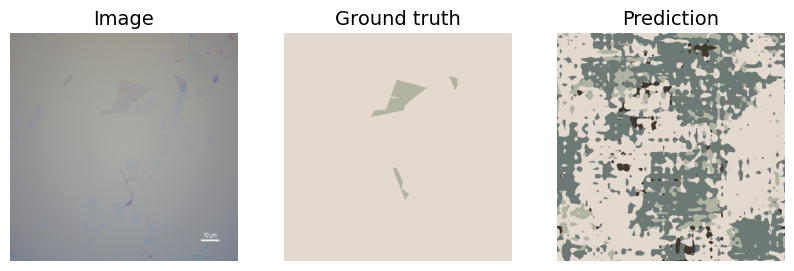

In [65]:
#@title Check functions that get a picture from predictions
for image, true_mask in val_generator:
  img = torch.FloatTensor(image[0]).to(device)
  pred_segm = get_prediction_pictures(img, lit_model.to(device))

  true_mask = true_mask[0].to(device)
  true_segm = get_pictures(true_mask)
  print_images([unnormalize(image[0]), true_segm.to(torch.uint8), pred_segm.to(torch.uint8)],
               ['Image', 'Ground truth', 'Prediction'])
  break

In [255]:
#@title Logging checkpoint

class PredictionsLogger(pl.callbacks.Callback):

  def __init__(self,
               log_n_pictures=5,
               log_every_n_epochs=1,
               plot_n_pictures=0,
               plot_every_n_epochs=0):
    super().__init__()

    self.epoch_counter = 0

    assert log_n_pictures <= dataset_val.num_images
    assert plot_n_pictures <= dataset_val.num_images

    self.log_n_pictures = log_n_pictures
    self.log_every_n_epochs = log_every_n_epochs
    self.plot_n_pictures = plot_n_pictures
    self.plot_every_n_epochs = plot_every_n_epochs

  def on_train_epoch_end(self, trainer, pl_module):
    pl_module.eval()
    table = wandb.Table(['Image', 'Ground Truth', 'Prediction'])
    if self.epoch_counter % self.plot_every_n_epochs == 0:
      print(f'===== EPOCH {self.epoch_counter} =====')
    with torch.no_grad():
      for idx in range(dataset_val.num_images):
        if idx >= max(self.plot_n_pictures, self.log_n_pictures):
          break
        image = dataset_val.load_image(idx, corrected=pl_module.apply_gamma_correction,
                                       median_corrected=pl_module.apply_median_correction) / 255.
        image = normalize(resize(image))
        t_image = torch.FloatTensor(image).to(device)
        pred_segm = get_prediction_pictures(t_image, pl_module)

        true_mask = resize(dataset_val.load_mask(idx)[0])
        t_true_mask = torch.FloatTensor(true_mask).to(device)
        true_segm = get_pictures(t_true_mask)

        if idx < self.log_n_pictures:
          table.add_data(wandb.Image(unnormalize(image).transpose((1, 2, 0))),
                         # convetring to numpy, because torch.Tensor.clump_(a, b) doesn't work if tensor is int and a, b are floats
                         wandb.Image(true_segm.cpu().numpy().transpose((1, 2, 0))),
                         wandb.Image(pred_segm.cpu().numpy().transpose((1, 2, 0))),
                         )
        if self.epoch_counter % self.plot_every_n_epochs == 0 and idx < self.plot_n_pictures:
          print_images(
            [unnormalize(image), true_segm.cpu().numpy().astype(np.uint8), pred_segm.cpu().numpy().astype(np.uint8)],
            ['Image', 'Ground Truth', 'Prediction'],
            [{}, {'cmap': 'gray'}, {'cmap': 'gray'}])

    if self.epoch_counter % self.log_every_n_epochs == 0:
      wandb.log({'segmentation_table': table}, commit=False)
      pass

    self.epoch_counter += 1


In [256]:
#@title Configuring predictions logger and printer

prediction_logger = PredictionsLogger(log_n_pictures=dataset_val.num_images, plot_n_pictures=5, plot_every_n_epochs=5)

In [257]:
#@title Logger

def get_run_name(model: LitOCR):
  return f'ocr_{model.backbone}_{"whole-data" if model.load_scraped else "no-scraped-data"}_{"with-correction" if model.apply_gamma_correction else "no-correction"}_{"median" if model.apply_median_correction else "no-median"}'


wandb_logger = pl.loggers.WandbLogger(save_dir=LOG_DIR,
                                      name=get_run_name(lit_model))

In [258]:
#@title Checkpoint callback

checkpoint_save = pl.callbacks.ModelCheckpoint(dirpath=CHECKPOINT_DIR,
                                               filename=wandb.run.name + '_{epoch}',
                                               monitor='val/loss',
                                               mode='min',
                                               save_top_k=1,
                                               )

In [259]:
#@title Trainer

trainer = pl.Trainer(default_root_dir=PROJECT_DIR,
                     limit_train_batches=50,
                     limit_val_batches=1,
                     callbacks=[checkpoint_save, prediction_logger],
                     max_epochs=MAX_EPOCHS,
                     logger=wandb_logger,
                     accelerator='gpu',
                     devices=[0]
                     )

INFO: GPU available: True (cuda), used: True
2023-05-06 11:06:23,638 INFO    GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2023-05-06 11:06:23,640 INFO    TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2023-05-06 11:06:23,642 INFO    IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2023-05-06 11:06:23,645 INFO    HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
2023-05-06 11:06:23,647 INFO    `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


INFO: You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-05-06 11:06:25,363 INFO    You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/coder/.local/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/coder/project/resources/models/OCRNet/checkpoints exists and is not empty.
  rank_zero_warn(f"Chec

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

===== EPOCH 0 =====


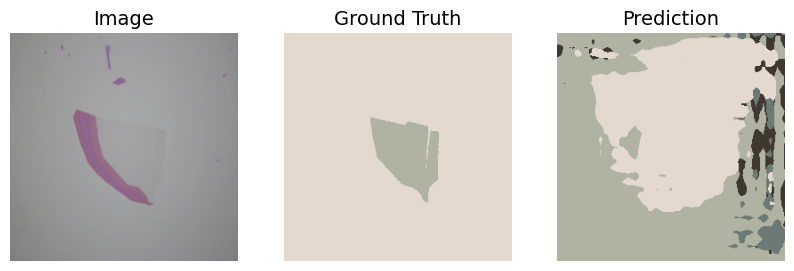

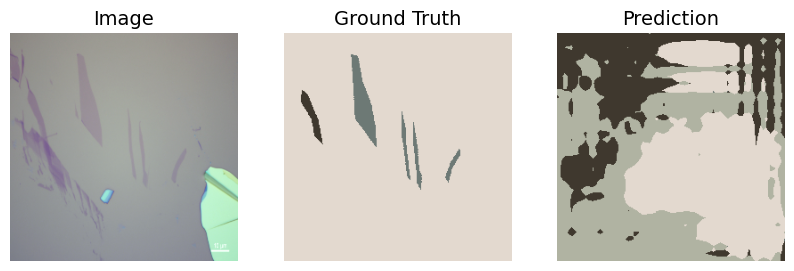

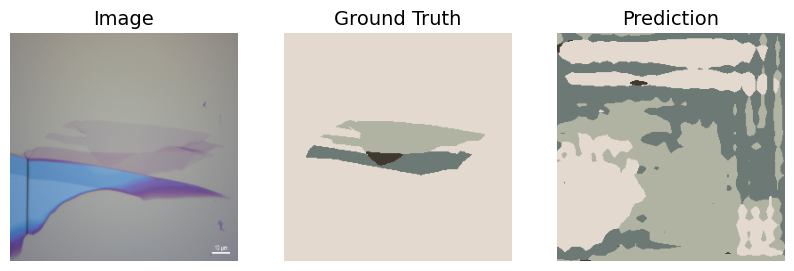

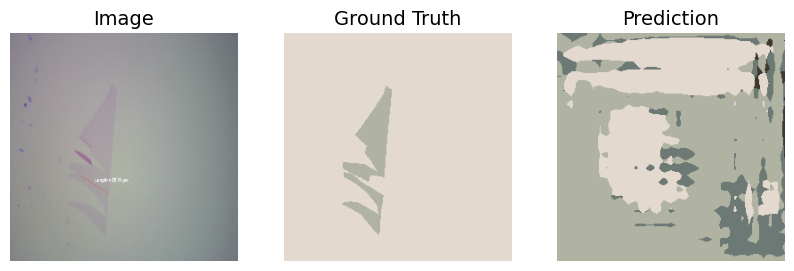

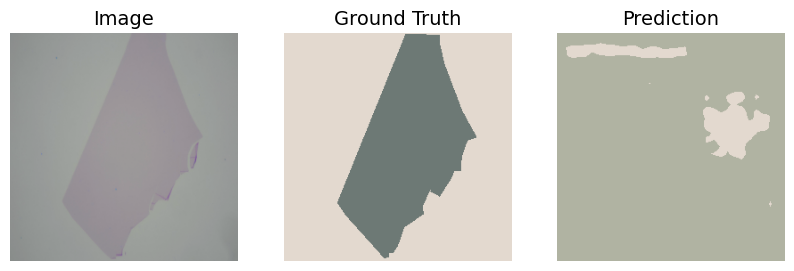

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

===== EPOCH 5 =====


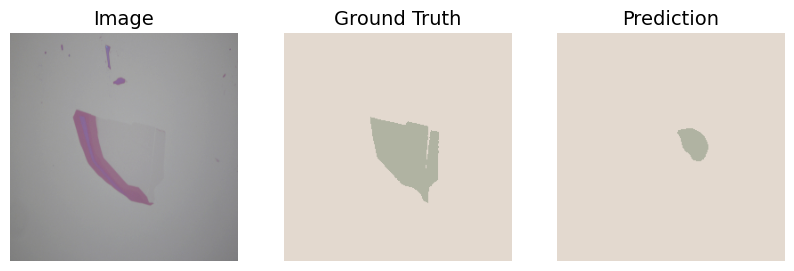

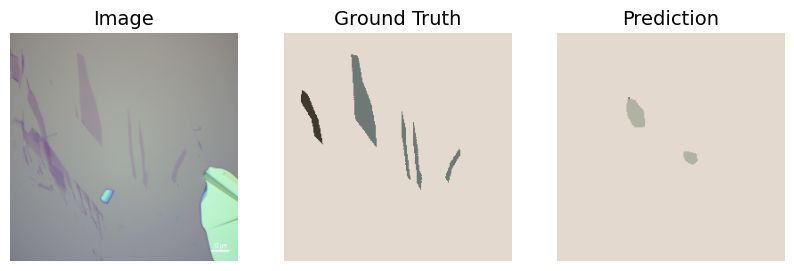

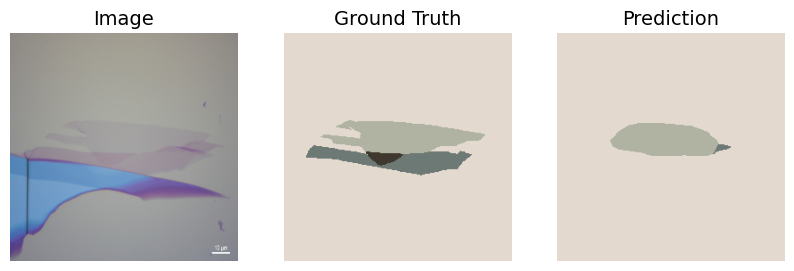

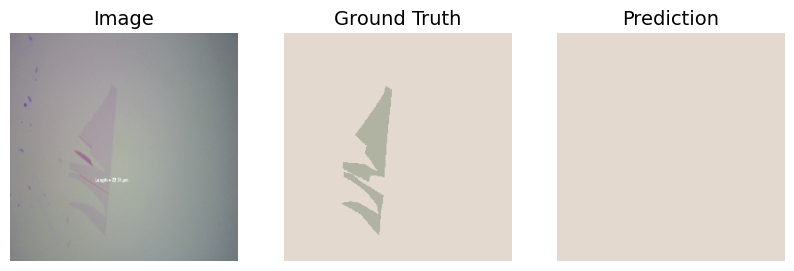

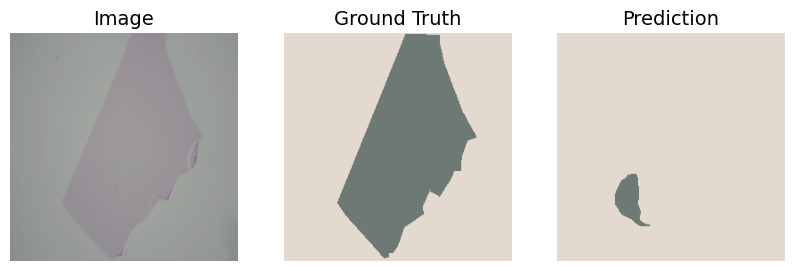

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

===== EPOCH 10 =====


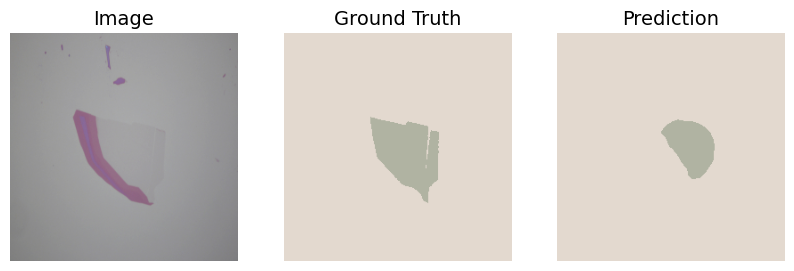

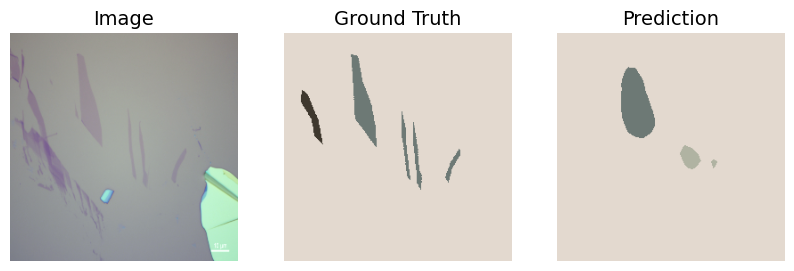

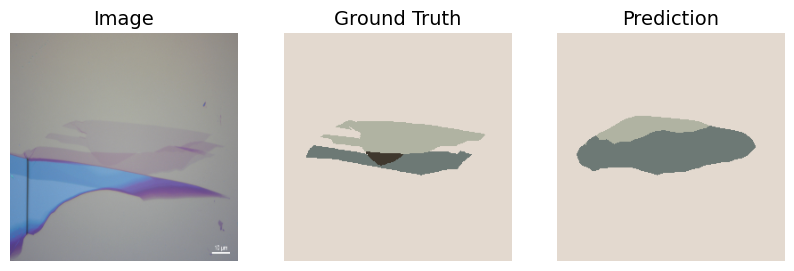

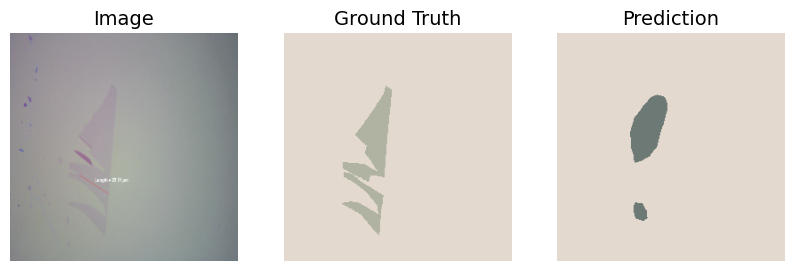

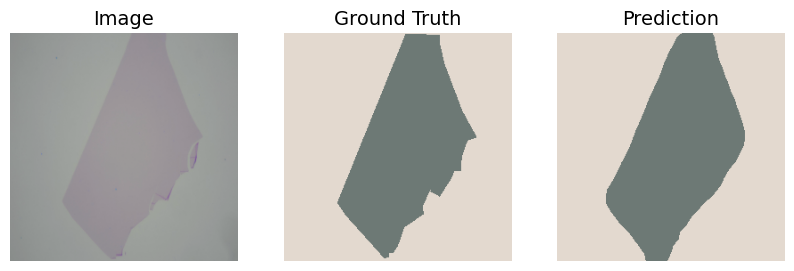

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

===== EPOCH 15 =====


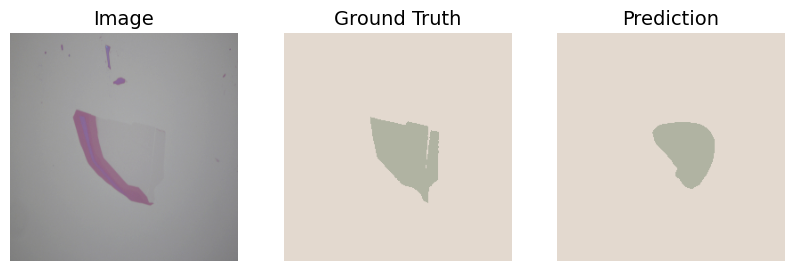

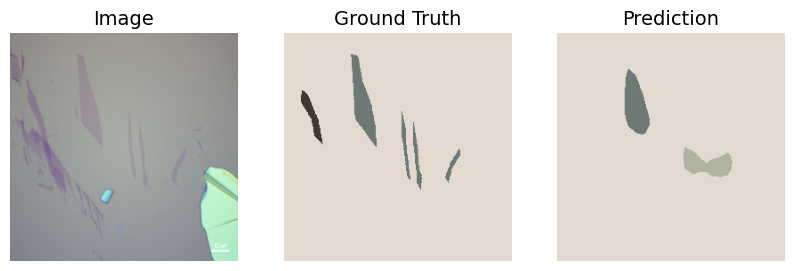

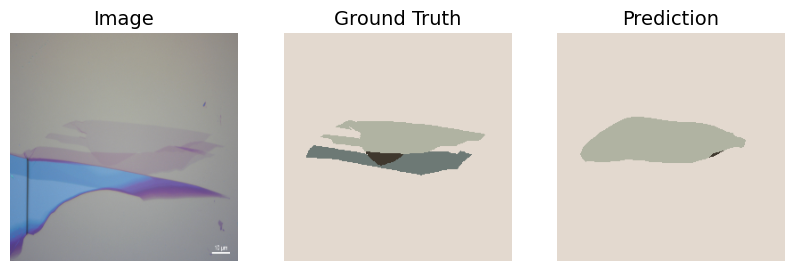

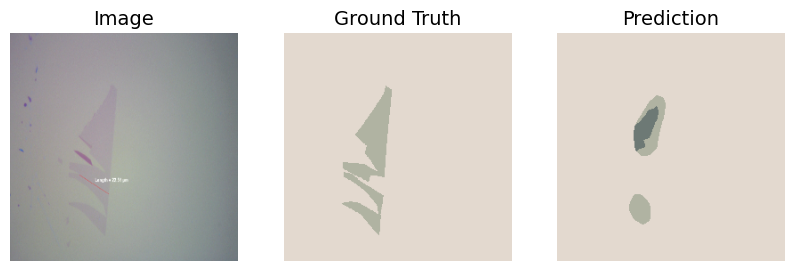

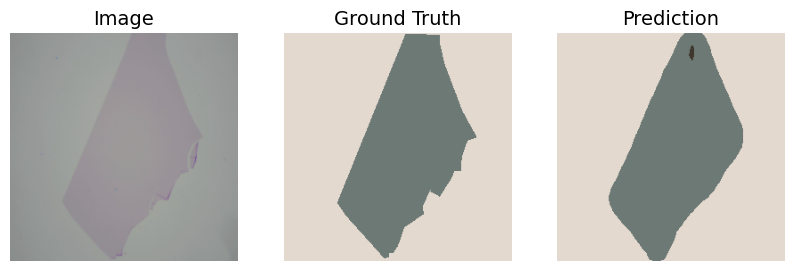

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

===== EPOCH 20 =====


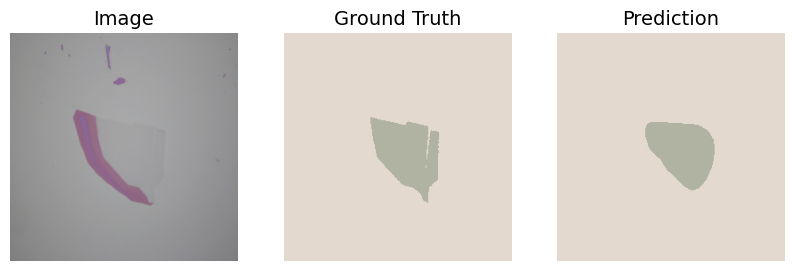

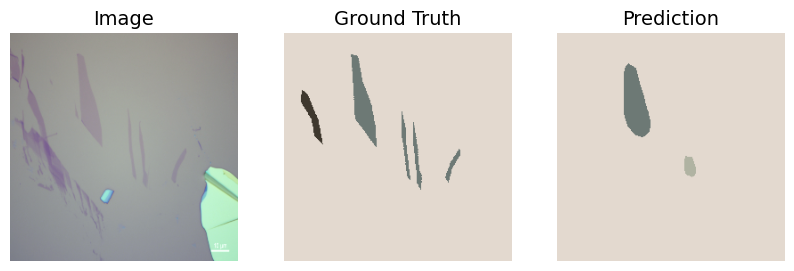

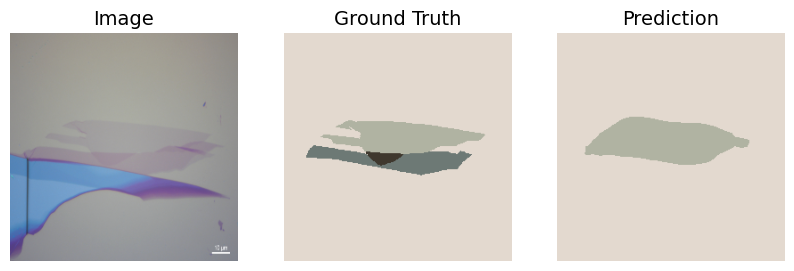

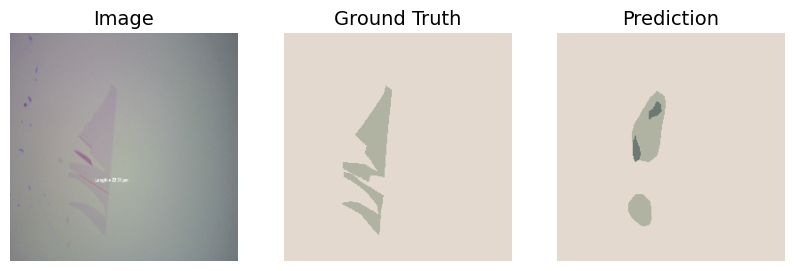

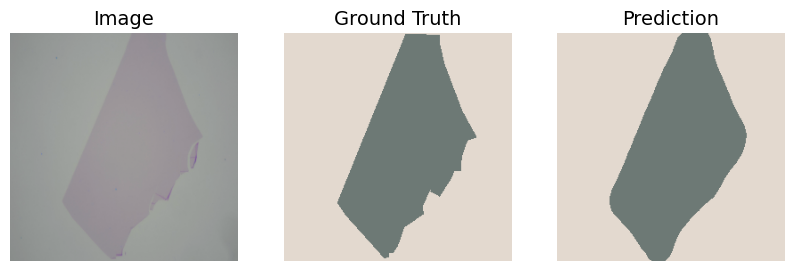

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

===== EPOCH 25 =====


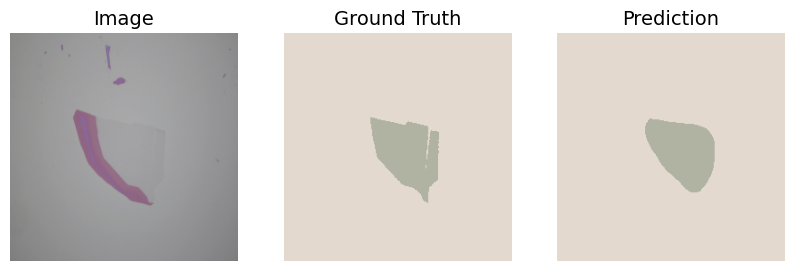

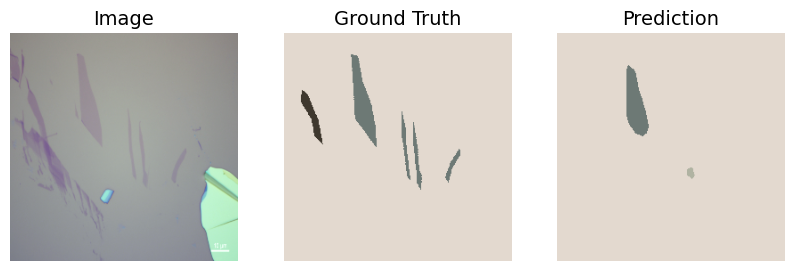

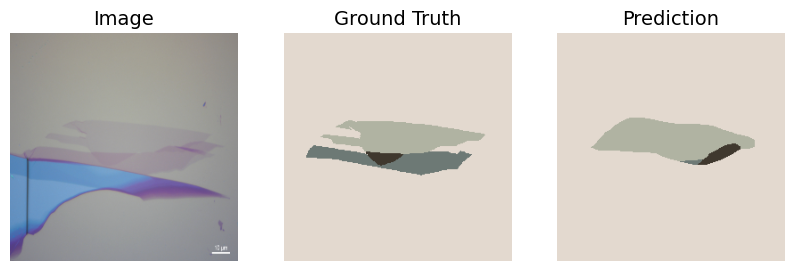

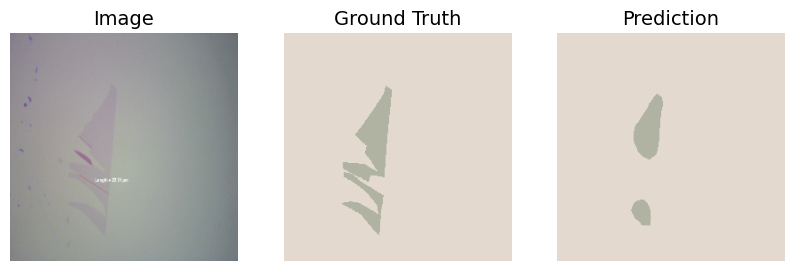

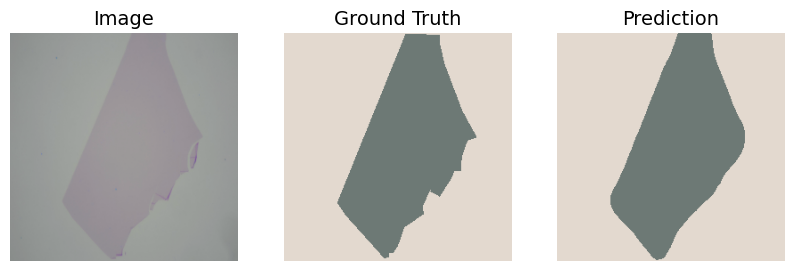

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

===== EPOCH 30 =====


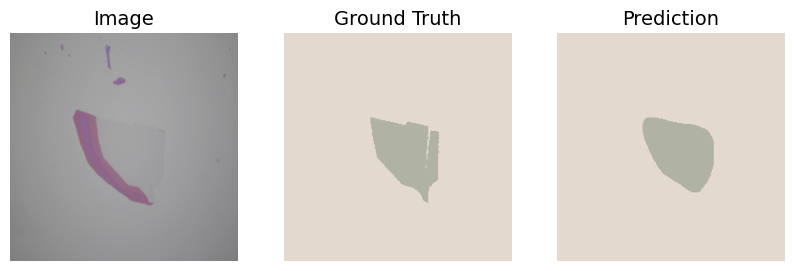

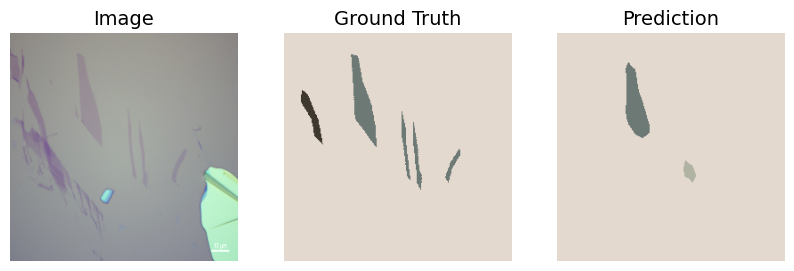

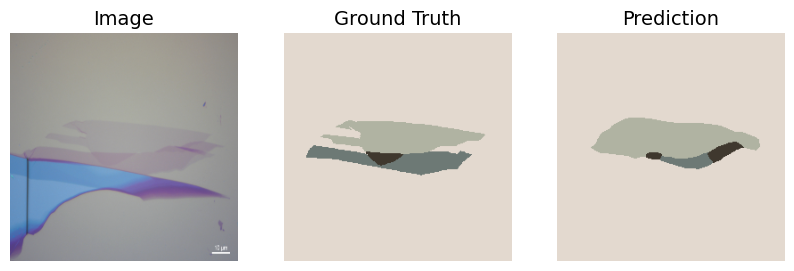

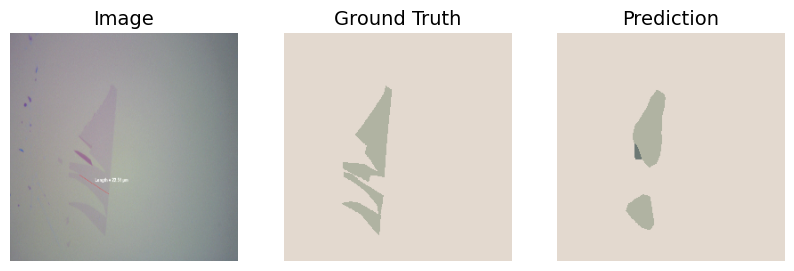

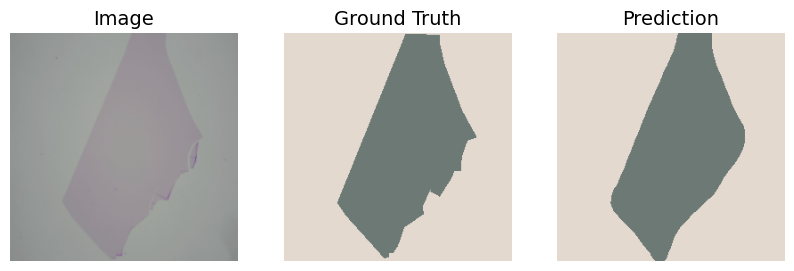

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

===== EPOCH 35 =====


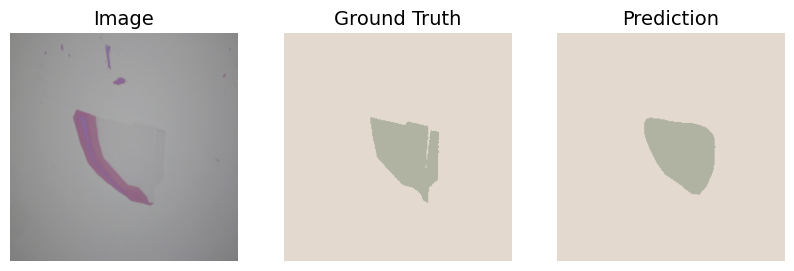

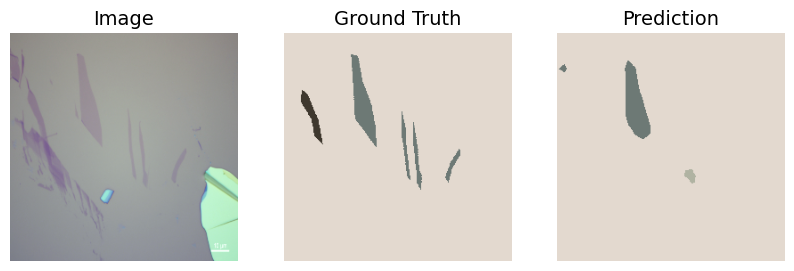

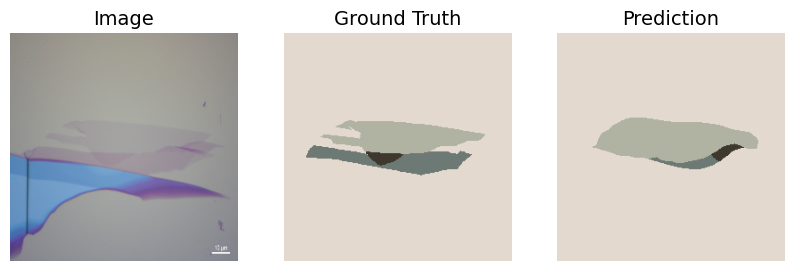

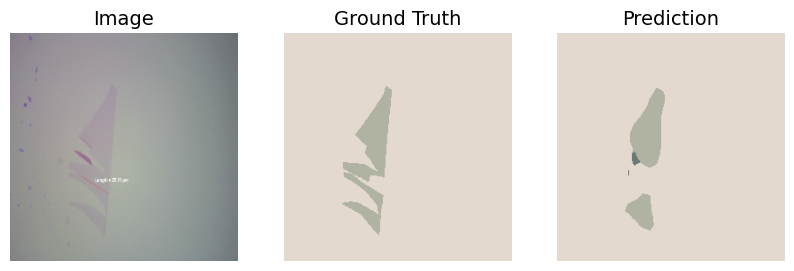

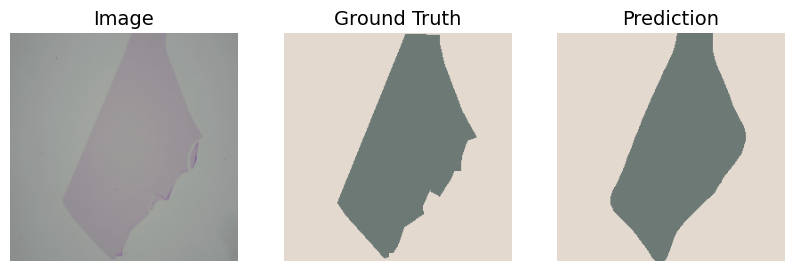

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

===== EPOCH 40 =====


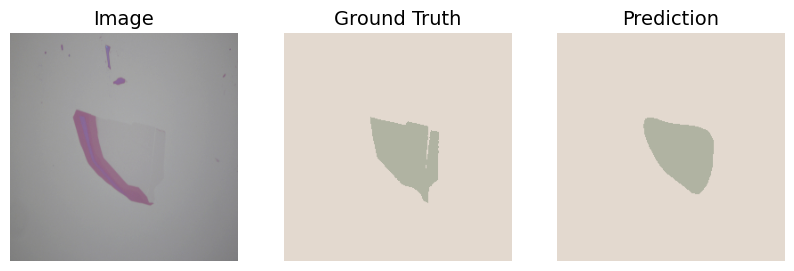

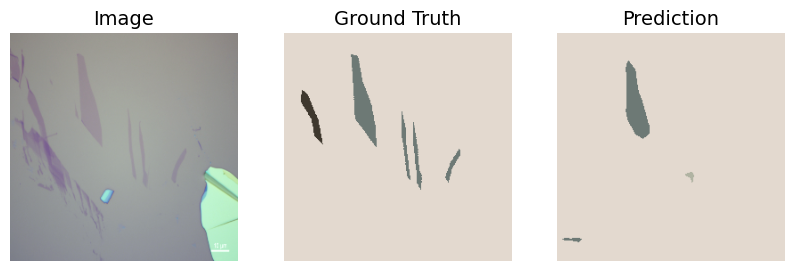

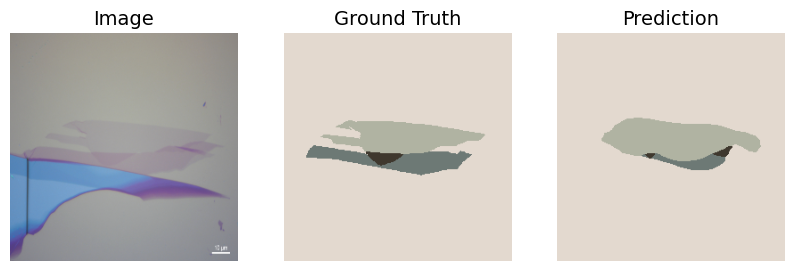

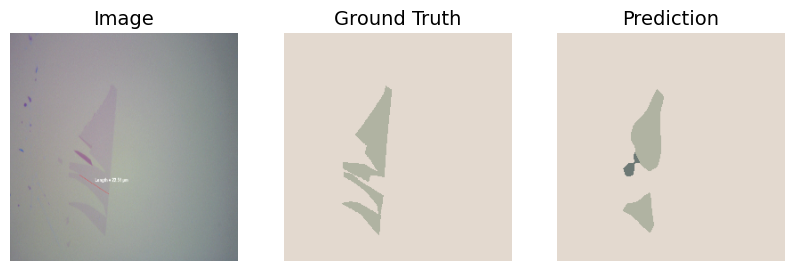

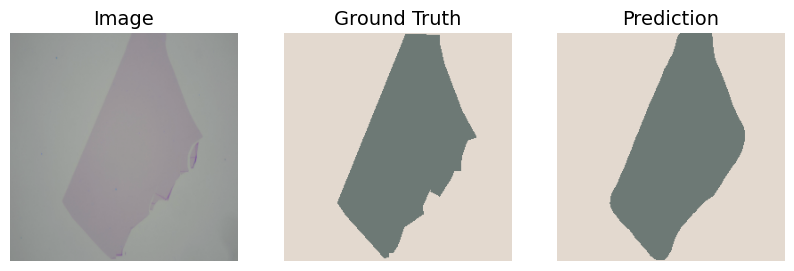

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

===== EPOCH 45 =====


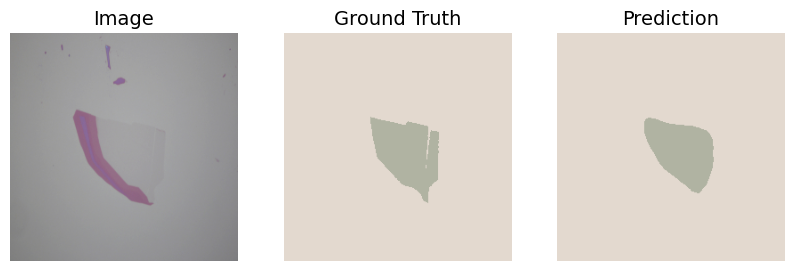

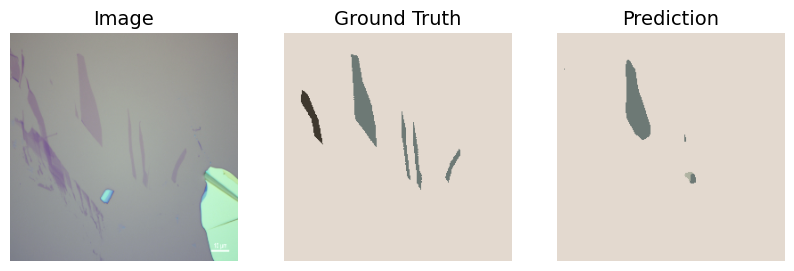

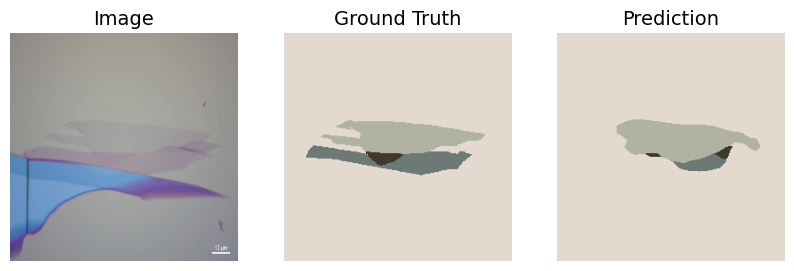

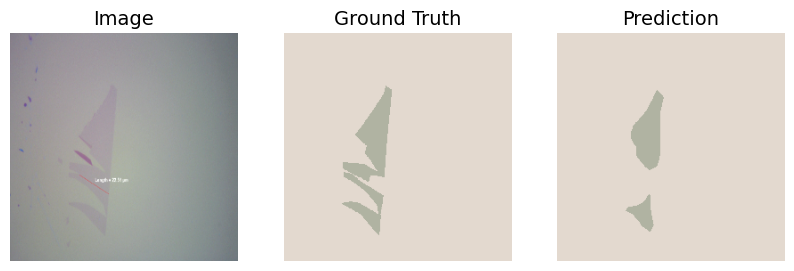

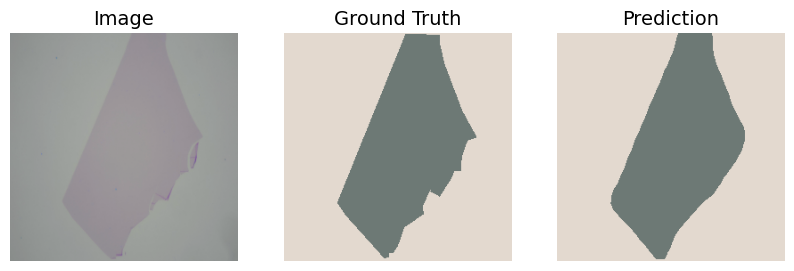

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
2023-05-06 12:47:31,214 INFO    `Trainer.fit` stopped: `max_epochs=50` reached.


In [260]:
trainer.fit(model=lit_model, train_dataloaders=train_generator, val_dataloaders=val_generator)

## Gather statistics

In [66]:
#@title Report table logging function
from sklearn.metrics import classification_report, confusion_matrix


def log_report_table(y_true, y_pred, class_names, metrics, table_name):
  if wandb.run is None:
    print("There is no wandb run")
    return
  report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
  table = wandb.Table(['class', *metrics])
  for class_name in class_names:
    table.add_data(class_name, *[report[class_name][metric] for metric in metrics])
  wandb.log({table_name: table})

In [67]:
#@title Prediction and target extracting function
def get_pred_target(dataset: Dataset, model: LitOCR, device='cuda'):
  with torch.no_grad():
    preds = []
    targets = []
    for i in tqdm(range(dataset.num_images), position=0, leave=True):
      image = torch.FloatTensor(normalize(resize(dataset.load_image(i, corrected=APPLY_GAMMA_CORRECTION) / 255.))).to(
        device)
      preds.append(model(image[None, :, :, :]).squeeze().cpu().numpy().argmax(axis=0))
      targets.append(resize(dataset.load_mask(i)[0]).argmax(axis=0))
  return np.concatenate(preds, axis=0).flatten(), np.concatenate(targets, axis=0).flatten()

In [68]:
#@title load a checkpoint

# BEST_MODEL_PATH = checkpoint_save.best_model_path 
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, 'ocr_resnet_no-scraped-data_no-correction_median_epoch=48.ckpt')

lit_model = LitOCR.load_from_checkpoint(BEST_MODEL_PATH, map_location=device).to(device)
lit_model.eval()
None

2023-05-07 12:50:22,030 INFO    [module_helper.py, 119] Loading pretrained model:../resources/models\OCRNet\pretrained\resnet101-imagenet.pth


In [69]:
#@title Get train predictions and targets
train_pred, train_target = get_pred_target(dataset_train, lit_model, device)

100%|██████████| 98/98 [04:23<00:00,  2.69s/it]


In [70]:
#@title Get val predictions and targets
val_pred, val_target = get_pred_target(dataset_val, lit_model, device)

100%|██████████| 11/11 [00:30<00:00,  2.73s/it]


In [72]:
#@title Look at classification reports

train_report = classification_report(train_target, train_pred, target_names=list(label_to_name.values()))
print(f'===== TRAIN REPORT ====\n{train_report}')

val_report = classification_report(val_target, val_pred, target_names=list(label_to_name.values()))
print(f'===== VAL REPORT ====\n{val_report}')

===== TRAIN REPORT ====
              precision    recall  f1-score   support

  Background       0.99      0.99      0.99  22782035
   Monolayer       0.74      0.91      0.82    832405
     Bilayer       0.79      0.70      0.74    632503
Three layers       0.74      0.83      0.78    253057

    accuracy                           0.98  24500000
   macro avg       0.82      0.86      0.83  24500000
weighted avg       0.98      0.98      0.98  24500000

===== VAL REPORT ====
              precision    recall  f1-score   support

  Background       0.99      0.99      0.99   2511547
   Monolayer       0.61      0.86      0.71    101495
     Bilayer       0.76      0.44      0.56    122911
Three layers       0.26      0.79      0.40     14047

    accuracy                           0.96   2750000
   macro avg       0.66      0.77      0.66   2750000
weighted avg       0.96      0.96      0.96   2750000



Trained on 256x256, evaluated on 256x256:
```
===== TRAIN REPORT ====
              precision    recall  f1-score   support

  Background       0.99      0.99      0.99   5972388
   Monolayer       0.83      0.87      0.85    218005
     Bilayer       0.86      0.82      0.84    165870
Three layers       0.85      0.84      0.84     66265

    accuracy                           0.98   6422528
   macro avg       0.88      0.88      0.88   6422528
weighted avg       0.98      0.98      0.98   6422528

===== VAL REPORT ====
              precision    recall  f1-score   support

  Background       0.99      0.99      0.99    658402
   Monolayer       0.86      0.83      0.85     26584
     Bilayer       0.85      0.73      0.78     32224
Three layers       0.31      0.76      0.44      3686

    accuracy                           0.97    720896
   macro avg       0.75      0.83      0.77    720896
weighted avg       0.97      0.97      0.97    720896
```

Trained on 256x256, evaluated on 500x500:
```
===== TRAIN REPORT ====
              precision    recall  f1-score   support

  Background       0.99      0.99      0.99  22782035
   Monolayer       0.74      0.91      0.82    832405
     Bilayer       0.79      0.70      0.74    632503
Three layers       0.74      0.83      0.78    253057

    accuracy                           0.98  24500000
   macro avg       0.82      0.86      0.83  24500000
weighted avg       0.98      0.98      0.98  24500000

===== VAL REPORT ====
              precision    recall  f1-score   support

  Background       0.99      0.99      0.99   2511547
   Monolayer       0.61      0.86      0.71    101495
     Bilayer       0.76      0.44      0.56    122911
Three layers       0.26      0.79      0.40     14047

    accuracy                           0.96   2750000
   macro avg       0.66      0.77      0.66   2750000
weighted avg       0.96      0.96      0.96   2750000
```

In [41]:


#@title Log classification reports

metrics = ['precision', 'recall', 'f1-score', 'support']
log_report_table(train_target, train_pred, label_to_name.values(), metrics, 'train/report')
log_report_table(val_target, val_pred, label_to_name.values(), metrics, 'val/report')

There is no wandb run
There is no wandb run


In [277]:
#@title Log confusion matrix

if wandb.run is not None:
  wandb.log({'val/confusion_matrix': wandb.plot.confusion_matrix(probs=None,
                                                                 y_true=val_target,
                                                                 preds=val_pred,
                                                                 class_names=list(label_to_name.values()),
                                                                 )
             })

  wandb.log({'train/confusion_matrix': wandb.plot.confusion_matrix(probs=None,
                                                                   y_true=train_target,
                                                                   preds=train_pred,
                                                                   class_names=list(label_to_name.values()),
                                                                   )
             })

In [278]:
#@title Print predicitons and get metrics
def get_val_prec_rec_iou(model, device='cpu'):
  model.eval()
  iou = torchmetrics.classification.JaccardIndex(task='multiclass', num_classes=NUM_CLASSES, average='macro').to(device)
  precision = torchmetrics.classification.Precision(task='multiclass', num_classes=NUM_CLASSES, average='macro').to(
    device)
  recall = torchmetrics.classification.Recall(task='multiclass', num_classes=NUM_CLASSES, average='macro').to(device)

  for images, targets in val_generator:
    pred = model(images.to(device))
    targets = torch.argmax(targets.to(device), dim=1)

    pred = torch.argmax(pred, dim=1, keepdim=True)
    segm = torch.zeros(size=(pred.shape[0], 3, pred.shape[2], pred.shape[3])).to(device)
    true_segm = torch.zeros(size=(pred.shape[0], 3, pred.shape[2], pred.shape[3])).to(device)
    for label, ind in label_to_ind.items():
      segm += (pred == ind) * label_to_color[label].to(device)[None, :, None, None]
      true_segm += (targets[:, None, :, :] == ind) * label_to_color[label].to(device)[None, :, None, None]

    pred_segm = get_prediction_pictures(images.to(device), model)
    # print(torch.cat(images.split(1), dim=1).shape)

    pred = pred.squeeze()

    print_images([torch.cat(unnormalize(images).split(1), dim=2).squeeze().to(torch.float),
                  torch.cat(true_segm.split(1), dim=2).squeeze().to(torch.uint8),
                  torch.cat(segm.split(1), dim=2).squeeze().to(torch.uint8)],
                 ["Image", "Ground Truth", "Segmentation"])

    precision(pred, targets)
    recall(pred, targets)
    iou(pred, targets)
    break

  return precision.compute(), recall.compute(), iou.compute()


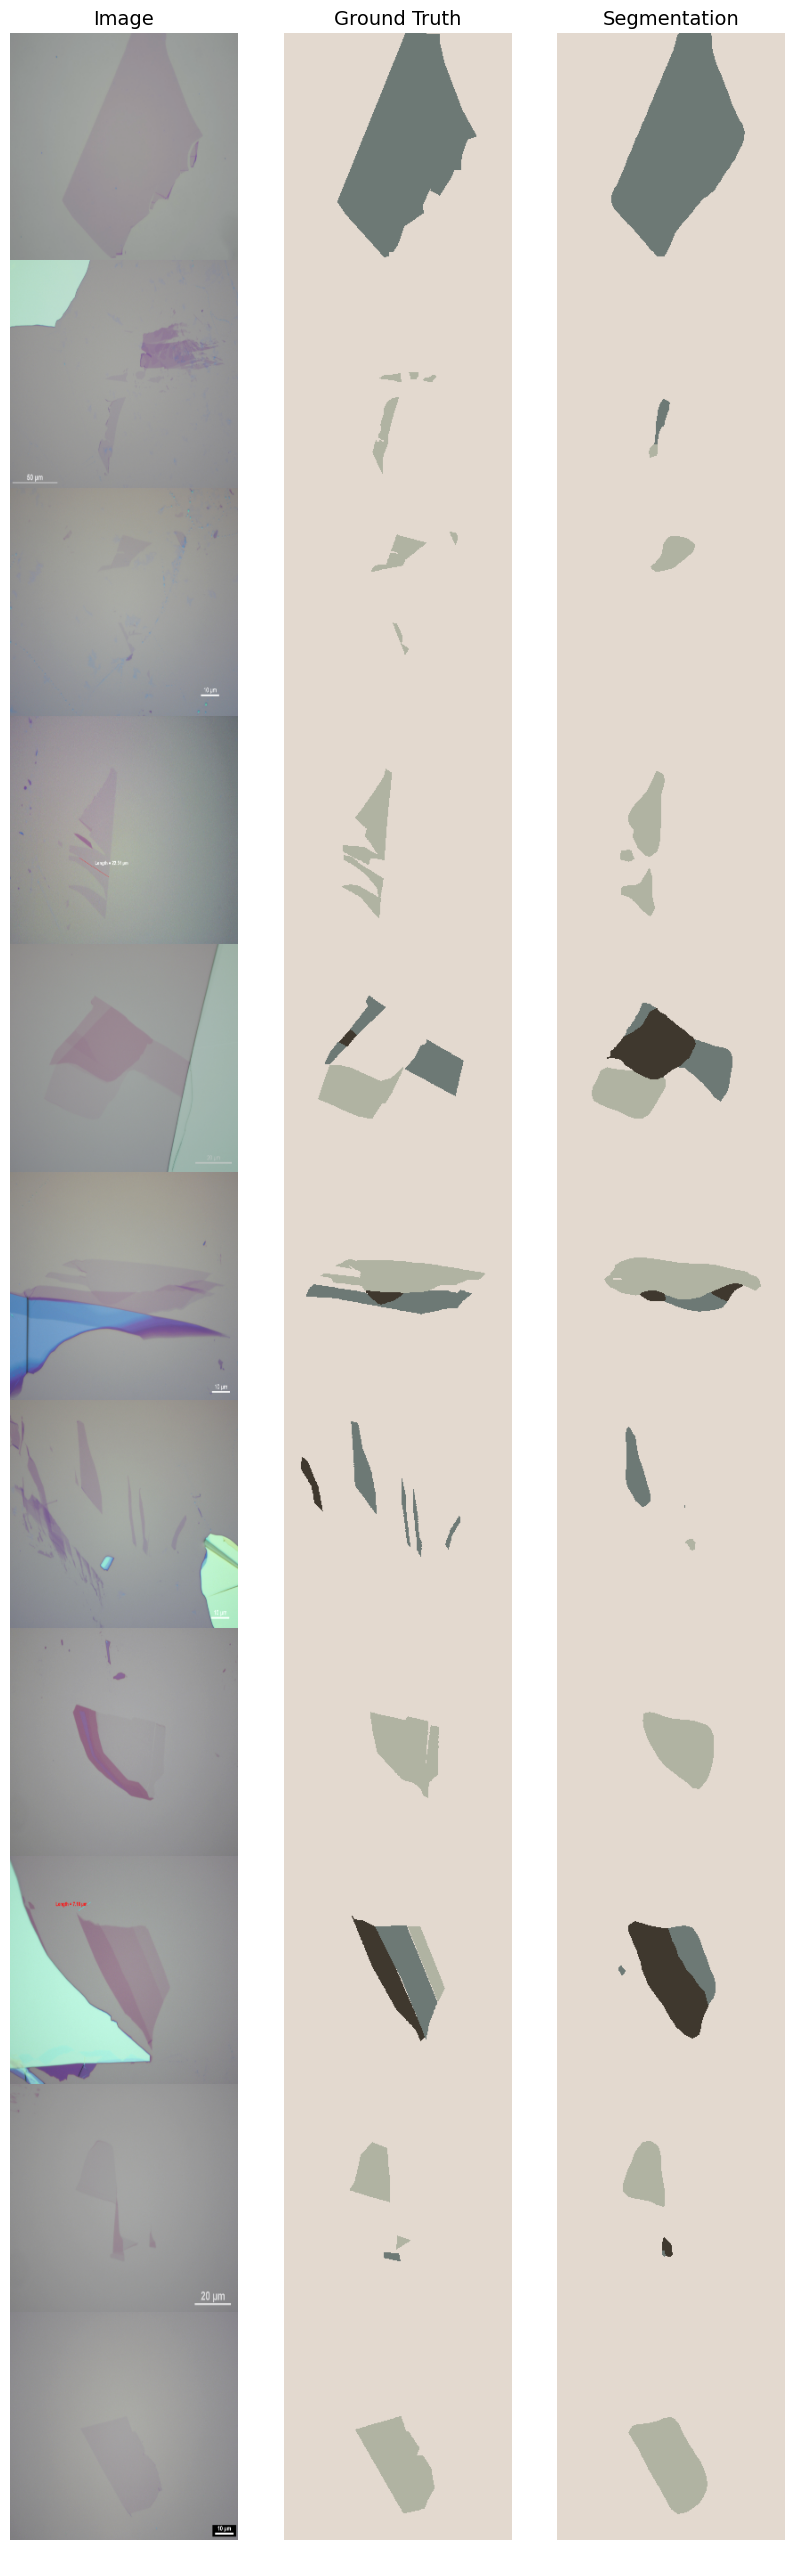

In [281]:
metrics = get_val_prec_rec_iou(lit_model, device)
torch.cuda.empty_cache()

In [282]:
metrics

(tensor(0.7592, device='cuda:0'),
 tensor(0.8530, device='cuda:0'),
 tensor(0.6779, device='cuda:0'))

In [283]:
wandb.finish()

## Save ONNX

In [116]:
input = torch.randn(1, 3, 256, 256)

input_names = ['input']
output_names = ['output']

torch.onnx.export(lit_model.model, input, os.path.join(PROJECT_DIR, 'onnx', 'ocrnet_resnet256.onnx'), verbose=True, input_names=input_names, output_names=output_names)

In [117]:
import onnx

# Load the ONNX model
model = onnx.load(os.path.join(PROJECT_DIR, 'onnx', 'ocrnet_resnet256.onnx'))

# Check that the model is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

graph torch_jit (
  %input[FLOAT, 1x3x256x256]
) initializers (
  %head.weight[FLOAT, 4x512x1x1]
  %head.bias[FLOAT, 4]
  %dsn_head.3.weight[FLOAT, 4x512x1x1]
  %dsn_head.3.bias[FLOAT, 4]
  %onnx::Conv_1196[FLOAT, 64x3x3x3]
  %onnx::Conv_1197[FLOAT, 64]
  %onnx::Conv_1199[FLOAT, 64x64x3x3]
  %onnx::Conv_1200[FLOAT, 64]
  %onnx::Conv_1202[FLOAT, 128x64x3x3]
  %onnx::Conv_1203[FLOAT, 128]
  %onnx::Conv_1205[FLOAT, 64x128x1x1]
  %onnx::Conv_1206[FLOAT, 64]
  %onnx::Conv_1208[FLOAT, 64x64x3x3]
  %onnx::Conv_1209[FLOAT, 64]
  %onnx::Conv_1211[FLOAT, 256x64x1x1]
  %onnx::Conv_1212[FLOAT, 256]
  %onnx::Conv_1214[FLOAT, 256x128x1x1]
  %onnx::Conv_1215[FLOAT, 256]
  %onnx::Conv_1217[FLOAT, 64x256x1x1]
  %onnx::Conv_1218[FLOAT, 64]
  %onnx::Conv_1220[FLOAT, 64x64x3x3]
  %onnx::Conv_1221[FLOAT, 64]
  %onnx::Conv_1223[FLOAT, 256x64x1x1]
  %onnx::Conv_1224[FLOAT, 256]
  %onnx::Conv_1226[FLOAT, 64x256x1x1]
  %onnx::Conv_1227[FLOAT, 64]
  %onnx::Conv_1229[FLOAT, 64x64x3x3]
  %onnx::Conv_1230[FLOAT, 6

In [151]:
import onnxruntime as ort
import numpy as np

# for i in tqdm(dataset_train.image_ids):
image = normalize(resize(dataset_val.load_image(3, median_corrected=True) / 255.))[None, :, :, :].astype(np.float32)
ort_sess = ort.InferenceSession(os.path.join(PROJECT_DIR, 'onnx', 'ocrnet_resnet256.onnx'))
outputs = ort_sess.run(None, {'input': image})
segm = get_pictures(torch.tensor(outputs[1]))

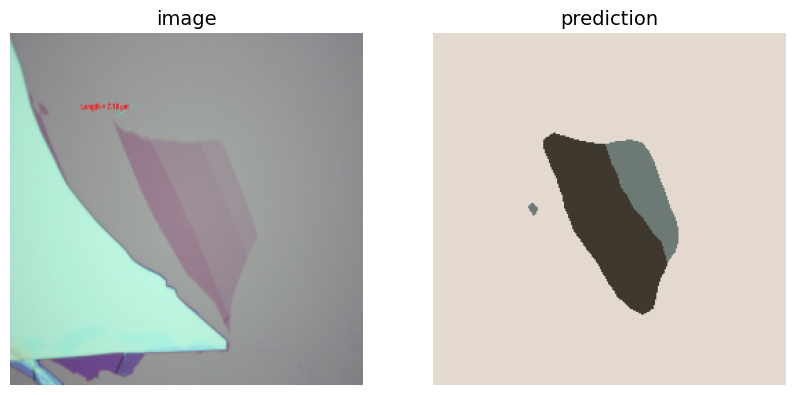

In [152]:
print_images([unnormalize(image[0]), segm[0].to(torch.uint8)], ['image', 'prediction'])